<a href="https://colab.research.google.com/github/SergeySmalkov/MarketMakingOptimizer/blob/main/MarketMakingOptimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

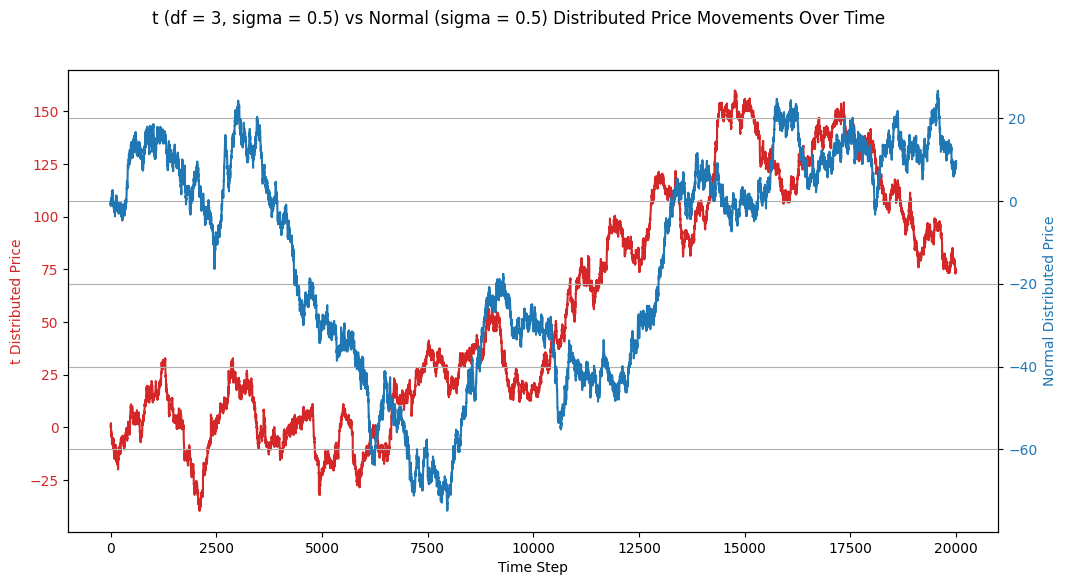

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
from scipy.stats import median_abs_deviation, t

# Set the parameters

sigma = 0.5  # Standard deviation for normal and Student's t-distribution
num_ticks = 20000

# Generate Normal distributed sequences of price changes
changes_normal = np.random.normal(scale=sigma, size=num_ticks)
sequence_normal = np.cumsum(changes_normal)


# Generate t-distributed sequences of price changes
df = 3  # degrees of freedom
changes_t = t.rvs(df, scale=sigma, size=num_ticks)
sequence_t = np.cumsum(changes_t)

# Generate a sequence of time steps
time_steps = np.arange(num_ticks)

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the t-distributed sequence on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Time Step')
ax1.set_ylabel('t Distributed Price', color=color)
ax1.plot(time_steps, sequence_t, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create the secondary y-axis and plot the normal-distributed sequence on it
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Normal Distributed Price', color=color)
ax2.plot(time_steps, sequence_normal, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
fig.suptitle(f't (df = {df}, sigma = {sigma}) vs Normal (sigma = {sigma}) Distributed Price Movements Over Time')
plt.grid(True)
plt.show()

<ipython-input-2-d0c582b55b1e>:53: UserWarning: The label '_child4' of <matplotlib.lines.Line2D object at 0x79dd6c3a6dd0> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=legend_elements, loc='upper right')
<ipython-input-2-d0c582b55b1e>:53: UserWarning: The label '_child6' of <matplotlib.lines.Line2D object at 0x79dd1fa94d60> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=legend_elements, loc='upper right')
<ipython-input-2-d0c582b55b1e>:53: UserWarning: The label '_child8' of <matplotlib.lines.Line2D object at 0x79dd1fad7250> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=legend_elements, loc='upper right')


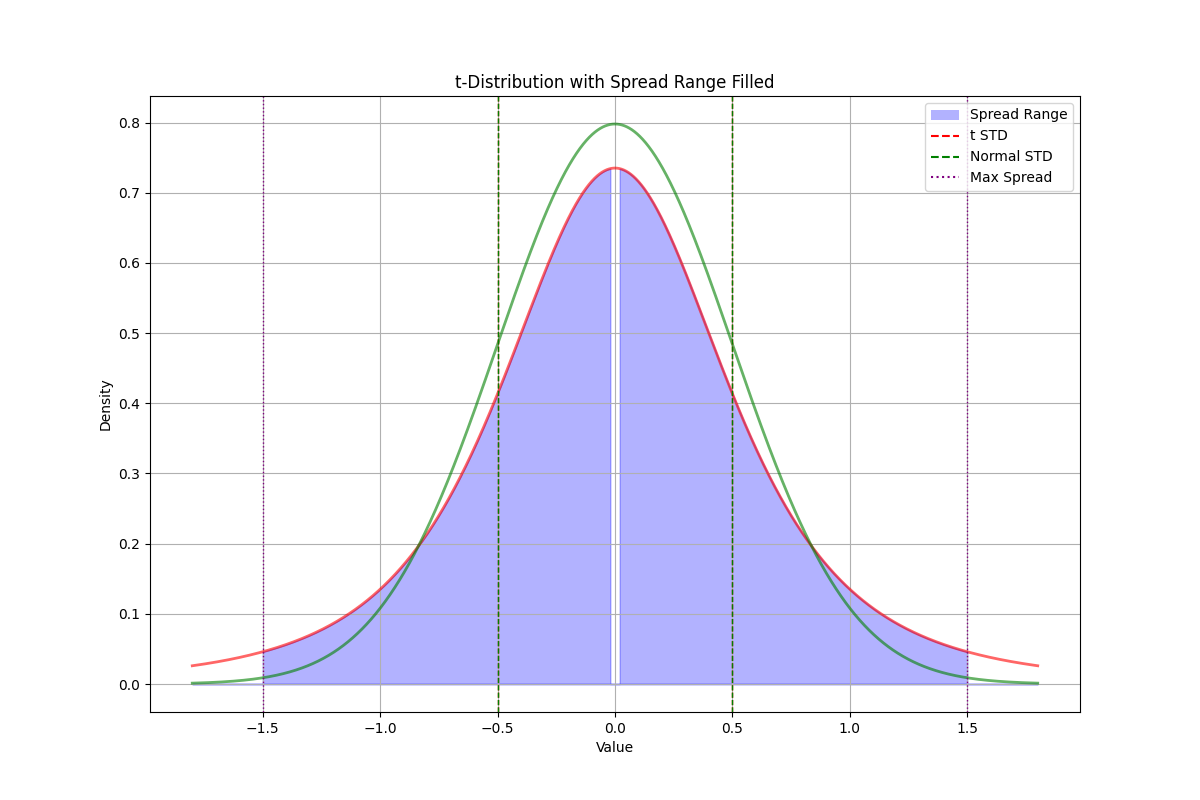

In [2]:
from scipy.stats import t, norm
from google.colab import output
output.enable_custom_widget_manager()
from mpl_interactions import ioff, panhandler, zoom_factory
%matplotlib widget
from matplotlib.patches import Patch
import matplotlib.lines as mlines
plt.close('all')

# Set the degrees of freedom for the t-distribution
df = 3  # adjust as needed
sigma = 0.5

min_half_spread = 0.02
max_half_spread = 1.5

x = np.linspace(-max_half_spread*1.2, max_half_spread*1.2, 1000000)

# Generate Normal distributed sequences
pdf_normal = norm.pdf(x, scale=sigma)
# Generate a more fine-grained set of x values for the t-distribution
pdf_t = t.pdf(x, df, scale=sigma)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(x, pdf_t, 'r-', lw=2, alpha=0.6, label='t pdf')
ax.plot(x, pdf_normal, 'g-', lw=2, alpha=0.6, label='Normal pdf')

spread_area = np.where((x >= min_half_spread) & (x <= max_half_spread), pdf_t, 0)
ax.fill_between(x, 0, spread_area, color='blue', alpha=0.3)

spread_area = np.where((-x >= min_half_spread) & (-x <= max_half_spread), pdf_t, 0)
ax.fill_between(x, 0, spread_area, color='blue', alpha=0.3)

t_line = ax.axvline(sigma, color='r', linestyle='dashed', linewidth=1)
ax.axvline(-sigma, color='r', linestyle='dashed', linewidth=1)
normal_line = ax.axvline(sigma, color='g', linestyle='dashed', linewidth=1)
ax.axvline(-sigma, color='g', linestyle='dashed', linewidth=1)

max_spread_line = ax.axvline(max_half_spread, color='purple', linestyle='dotted', linewidth=1)
ax.axvline(-max_half_spread, color='purple', linestyle='dotted', linewidth=1)

plt.title('t-Distribution with Spread Range Filled')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)

# Add legends for both lines and patches
legend_elements = [Patch(facecolor='blue', alpha=0.3, label='Spread Range'),
                   t_line, normal_line, max_spread_line,
                   mlines.Line2D([], [], color='r', linestyle='dashed', label='t STD'),
                   mlines.Line2D([], [], color='g', linestyle='dashed', label='Normal STD'),
                   mlines.Line2D([], [], color='purple', linestyle='dotted', label='Max Spread')]
ax.legend(handles=legend_elements, loc='upper right')
plt.show()


Market participant (our client) occasionally trades with the market maker. The client's decision to trade is modeled as a Bernoulli process, with a given probability of trading at each time step. If the client decides to trade, they choose to either buy or sell with equal probability (50:50).

This simulation allows the market maker to interact with this client, quoting bid and ask prices based on a spread around the mid price of the asset. The market maker's position will be affected by both the price movement of the asset and the trades with the client (markouts, since client has market impact). If the client buys and the market maker has a long position, the market maker sells to the client. If the client sells and the market maker has a short position, the market maker buys from the client. In the case of no position, the market maker can go short if the client wants to buy, and long if the client wants to sell.

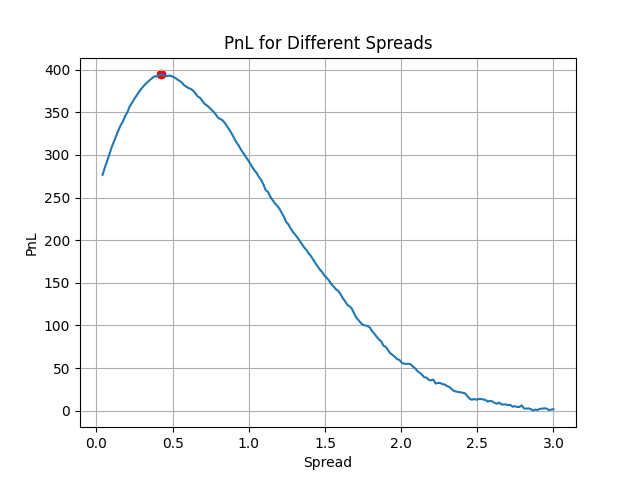

In [72]:
from numba import jit
plt.close('all')
# Define parameters

sigma = 0.5

min_half_spread = 0.02
max_half_spread = 1.5

spreads = np.linspace(min_half_spread * 2 , max_half_spread * 2, 200)  # range of spreads to be tested
commission = -0.45
num_sequences = 75
num_ticks = 5000

markout = 0.05  # constant external parameter for impact on mid price
probability_of_trade = 0.00  # probability of trade in the next tick

changes = np.random.normal(scale=sigma, size=(num_sequences, num_ticks))

# df = 3  # degrees of freedom
# changes = t.rvs(df, scale=sigma, size=(num_sequences, num_ticks))
# sequence = np.cumsum(changes)

# Generate the price sequences by taking the cumulative sum of the changes
sequences = np.cumsum(changes, axis=1)


# Create a sequence of client trades
client_trades = np.random.binomial(1, probability_of_trade, size=(num_sequences, num_ticks))
# Assign random directions to the trades: 1 for buy, -1 for sell
client_trade_directions = np.random.choice([1, -1], size=(num_sequences, num_ticks))

# Apply client trades impact to sequences
for i in range(num_sequences):
    sequences[i] += np.cumsum(client_trades[i] * client_trade_directions[i] * markout)


@jit(nopython=True)
def simulate_strategy(sequence, spread, client_trades, client_trade_directions):
    pnl = 0.0
    position = 0
    ask = bid = sequence[0]

    for i in range(1, len(sequence)):
        mid_price = sequence[i]
        ask = sequence[i-1] + spread / 2.0
        bid = sequence[i-1] - spread / 2.0
        client_trade = client_trades[i]
        client_trade_direction = client_trade_directions[i]


        if position == -1:  # we have a short position
            if (client_trade and client_trade_direction == -1) or mid_price <= bid:
                pnl -= 2 * (bid + commission)
                position = 1
            continue

        elif position == 1:  # we have a long position
            if (client_trade and client_trade_direction == 1) or mid_price >= ask:  # our ask is hit
                pnl += 2 * (ask - commission)  # we sell 2
                position = -1
            continue


        elif position == 0:
            if (client_trade and client_trade_direction == 1) or mid_price >= ask:  # our ask is hit
                pnl += (ask - commission)
                position = -1
            elif (client_trade and client_trade_direction == -1) or mid_price <= bid:
                pnl -= (bid + commission)
                position = 1
            continue


    # Close any open position at the end of the sequence
    if position != 0:
        pnl += position * sequence[-1] - commission
        position = 0

    return pnl

# Iterate over each spread and each sequence, accumulating PnL for each spread
pnls = np.zeros_like(spreads)
for i, spread in enumerate(spreads):
    for j, seq in enumerate(sequences):
        pnls[i] += simulate_strategy(seq, spread, client_trades[j], client_trade_directions[j])

pnls = pnls / num_sequences

# Plot the results
plt.plot(spreads, pnls)
plt.scatter(spreads[np.argmax(pnls)], pnls.max(), color='r')  # Mark the max PnL
plt.title("PnL for Different Spreads")
plt.xlabel("Spread")
plt.ylabel("PnL")
plt.grid(True)
plt.show()

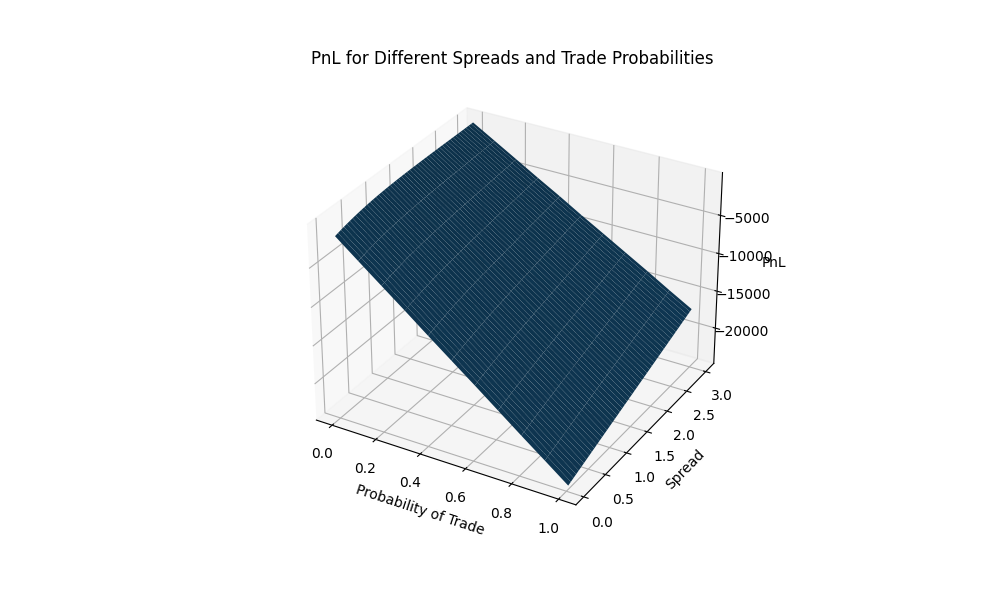

In [20]:
from mpl_toolkits.mplot3d import Axes3D
plt.close('all')
probability_of_trades = np.linspace(0.0, 1.0, 11)  # from 0.0 to 1.0 with step 0.1
pnls_surface = np.zeros((len(spreads), len(probability_of_trades)))

changes = np.random.normal(scale=sigma, size=(num_sequences, num_ticks))

# df = 3  # degrees of freedom
# changes = t.rvs(df, scale=sigma, size=(num_sequences, num_ticks))
# sequence = np.cumsum(changes)

# Generate the price sequences by taking the cumulative sum of the changes
sequences = np.cumsum(changes, axis=1)


@jit(nopython=True)
def calc(pnls_surface, initial_sequences, markout):
    for i, spread in enumerate(spreads):
        for j, probability_of_trade in enumerate(probability_of_trades):
            client_trades = np.random.binomial(1, probability_of_trade, size=(num_sequences, num_ticks))
            sequences = np.copy(initial_sequences)
            for k, seq in enumerate(sequences):
                # Apply client trades impact to sequences
                sequences[k] += np.cumsum(client_trades[k] * client_trade_directions[k] * markout)
                pnls_surface[i, j] += simulate_strategy(seq, spread, client_trades[k], client_trade_directions[k])
            pnls_surface[i, j] /= num_sequences
    return pnls_surface


# Save a copy of the initial sequences
initial_sequences = np.copy(sequences)

# Use the initial sequences in the calculation
pnls_surface = calc(pnls_surface, initial_sequences, markout)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(probability_of_trades, spreads)
ax.plot_surface(X, Y, pnls_surface)
ax.set_xlabel('Probability of Trade')
ax.set_ylabel('Spread')
ax.set_zlabel('PnL')
ax.set_title('PnL for Different Spreads and Trade Probabilities')
plt.show()

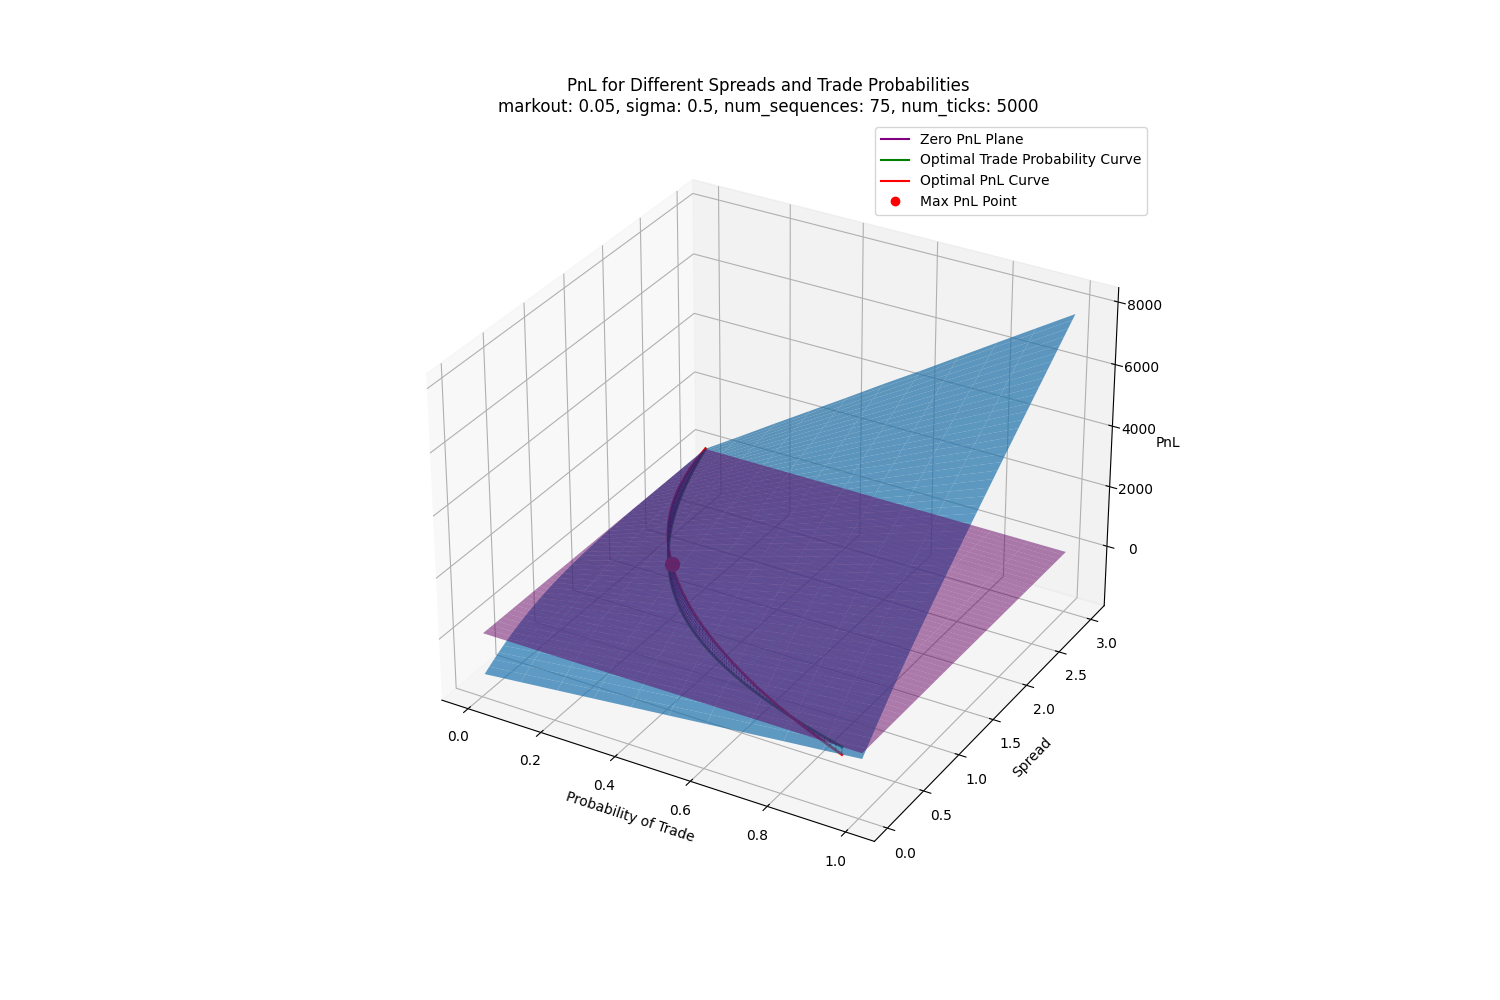

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RectBivariateSpline
import matplotlib.lines as mlines
plt.close('all')
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw the PnL surface
X, Y = np.meshgrid(probability_of_trades, spreads)
ax.plot_surface(X, Y, pnls_surface, alpha=0.7)

# Draw the zero PnL plane
Z = np.zeros_like(X)
ax.plot_surface(X, Y, Z, color='purple', alpha=0.5)

def prob_to_spread(spread):
    prob = 4/3 / (1 + spread) - 1/3
    return np.clip(prob, 0, 1)

# Calculate the probability for each spread
prob_from_spread = prob_to_spread(spreads)

# Create the continuous PnL surface
pnls_interpolated = RectBivariateSpline(spreads, probability_of_trades, pnls_surface)

# Calculate the PnLs for the green curve using the continuous PnL surface
red_curve_pnls = pnls_interpolated(spreads, prob_from_spread, grid=False)

# Find the maximum PnL position on red line
max_pnl_index = np.argmax(red_curve_pnls)

# Draw the green curve at zero PnL
ax.plot(prob_from_spread, spreads, np.zeros_like(spreads), 'g', linewidth=2)

# Draw the corresponding curve in 3D space (red curve)
ax.plot(prob_from_spread, spreads, red_curve_pnls, 'r', linewidth=2)

# Draw the point of max PnL on the red line
ax.scatter(prob_from_spread[max_pnl_index], spreads[max_pnl_index], red_curve_pnls[max_pnl_index], color='r', s=100)

# Connect the red and green curves
for i in range(len(spreads)):
    ax.plot([prob_from_spread[i], prob_from_spread[i]], [spreads[i], spreads[i]], [0, red_curve_pnls[i]], 'k--', linewidth=0.5)

ax.set_xlabel('Probability of Trade')
ax.set_ylabel('Spread')
ax.set_zlabel('PnL')
ax.set_title('PnL for Different Spreads and Trade Probabilities')

# Create custom legend
legend_elements = [mlines.Line2D([], [], color='purple', label='Zero PnL Plane'),
                   mlines.Line2D([], [], color='green', label='Optimal Trade Probability Curve'),
                   mlines.Line2D([], [], color='red', label='Optimal PnL Curve'),
                   mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Max PnL Point')]

ax.legend(handles=legend_elements, loc='best')
ax.set_title(f'PnL for Different Spreads and Trade Probabilities\n'
             f'markout: {markout}, sigma: {sigma}, '
             f'num_sequences: {num_sequences}, num_ticks: {num_ticks}')
plt.show()


In [68]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
import seaborn as sns
# Color map
cmap = plt.get_cmap('viridis')

plt.close('all')
# Set levels of sigma and markout to iterate over
sigma_levels = np.linspace(0.5, 1.5, 3)  # modify these values as per your needs
markout_levels = np.linspace(0.00, 1.2 , 3)  # modify these values as per your needs

probability_of_trades = np.linspace(0.0, 1.0, 11)  # from 0.0 to 1.0 with step 0.1

# Create dictionaries to store surfaces for each level
sigma_surfaces = {}
markout_surfaces = {}

markout = markout_levels[1]

# Iterate over sigma levels
for sigma in sigma_levels:
    pnls_surface = np.zeros((len(spreads), len(probability_of_trades)))
    changes = np.random.normal(scale=sigma, size=(num_sequences, num_ticks))
    initial_sequences = np.cumsum(changes, axis=1)
    pnls_surface = calc(pnls_surface, initial_sequences, markout)
    sigma_surfaces[sigma] = pnls_surface

sigma = sigma_levels[1]

# Iterate over markout levels
for markout in markout_levels:
    pnls_surface = np.zeros((len(spreads), len(probability_of_trades)))
    changes = np.random.normal(scale=sigma, size=(num_sequences, num_ticks))
    initial_sequences = np.cumsum(changes, axis=1)  # Recreate the original sequences without client impact
    pnls_surface = calc(pnls_surface, initial_sequences, markout)
    markout_surfaces[markout] = pnls_surface


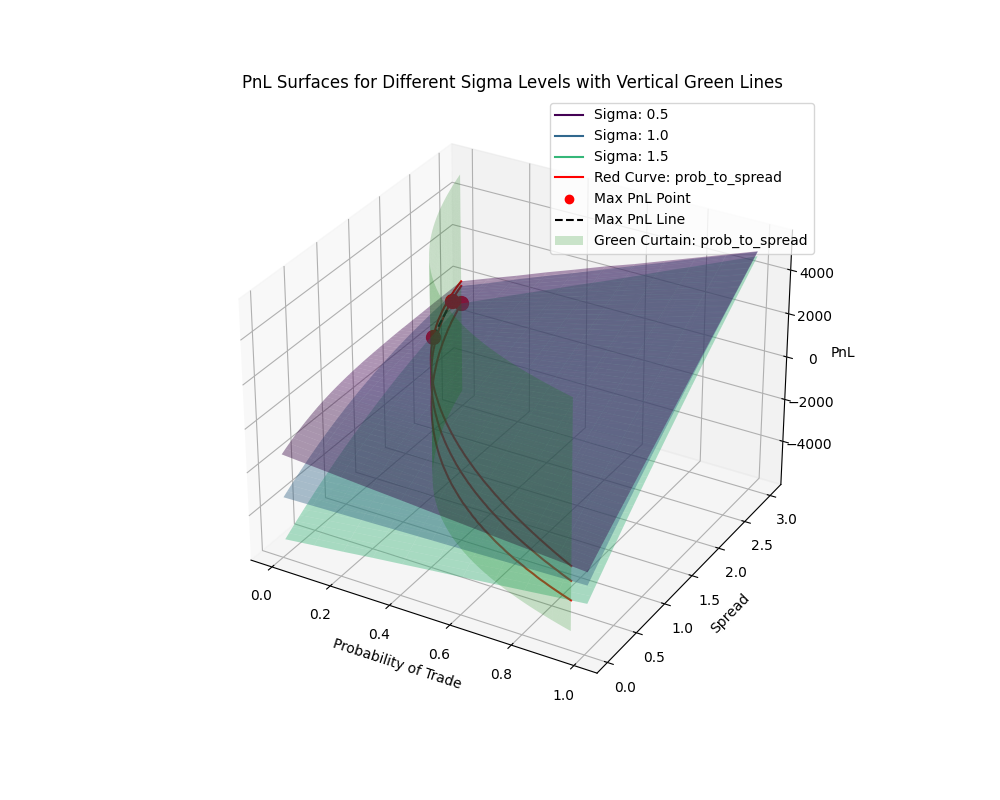

In [69]:
plt.close('all')

from scipy.interpolate import RectBivariateSpline

# Define function for finding maximum PnL and corresponding spread and probability

def find_max_pnl(spreads, probabilities, surface):
    max_pnl_index = np.argmax(surface)
    return spreads[max_pnl_index], probabilities[max_pnl_index], surface[max_pnl_index]

# Define min and max PnL values for the green "curtain"
min_pnl = np.min([np.min(surface) for surface in sigma_surfaces.values()])
max_pnl = np.max([np.max(surface) for surface in sigma_surfaces.values()])

# Create a meshgrid for the green "curtain"
Z_curtain, Y_curtain = np.meshgrid(np.linspace(min_pnl, max_pnl, 100), spreads)
X_curtain = np.tile(prob_from_spread, (100, 1)).T  # X is the same for every spread

# Initialize list to store maximum PnL points for each sigma level
max_pnl_points_sigma = []

# Plot surfaces for different sigma levels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('PnL Surfaces for Different Sigma Levels')
ax.set_xlabel('Probability of Trade')
ax.set_ylabel('Spread')
ax.set_zlabel('PnL')

for i, (sigma, surface) in enumerate(sigma_surfaces.items()):
    # Plot original PnL surface
    X, Y = np.meshgrid(probability_of_trades, spreads)
    ax.plot_surface(X, Y, surface, alpha=0.4, color=cmap(i / len(sigma_surfaces)))

    # Create the continuous PnL surface
    pnls_interpolated = RectBivariateSpline(spreads, probability_of_trades, surface)

    # Calculate the PnLs for the red curve using the continuous PnL surface
    red_curve_pnls = pnls_interpolated(spreads, prob_from_spread, grid=False)

    # Draw the red curve
    ax.plot(prob_from_spread, spreads, red_curve_pnls, 'r')

    # Find the maximum PnL on the red curve
    max_spread, max_prob, max_pnl = find_max_pnl(spreads, prob_from_spread, red_curve_pnls)
    max_pnl_points_sigma.append((max_prob, max_spread, max_pnl))

    # Draw the point of max PnL on the red line
    ax.scatter(max_prob, max_spread, max_pnl, color='r', s=100)

# Connect the max PnL points
max_pnl_points_sigma = np.array(max_pnl_points_sigma)
ax.plot(max_pnl_points_sigma[:, 0], max_pnl_points_sigma[:, 1], max_pnl_points_sigma[:, 2], 'k--')

# Draw the green "curtain"
ax.plot_surface(X_curtain, Y_curtain, Z_curtain, alpha=0.2, color='g')

# Create legend
legend_elements = [mlines.Line2D([], [], color=cmap(i / len(sigma_surfaces)), label=f'Sigma: {sigma}') for i, sigma in enumerate(sigma_surfaces)]
legend_elements.append(mlines.Line2D([], [], color='red', label='Max PnL Line from Sigma changes'))
legend_elements.append(mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Max PnL Point from Sigma changes'))
legend_elements.append(mlines.Line2D([], [], color='black', linestyle='dashed', label='Max PnL Line'))
legend_elements.append(Patch(facecolor='green', alpha=0.2, label='Client sensitivity to spread'))
ax.legend(handles=legend_elements, loc='best')

plt.show()


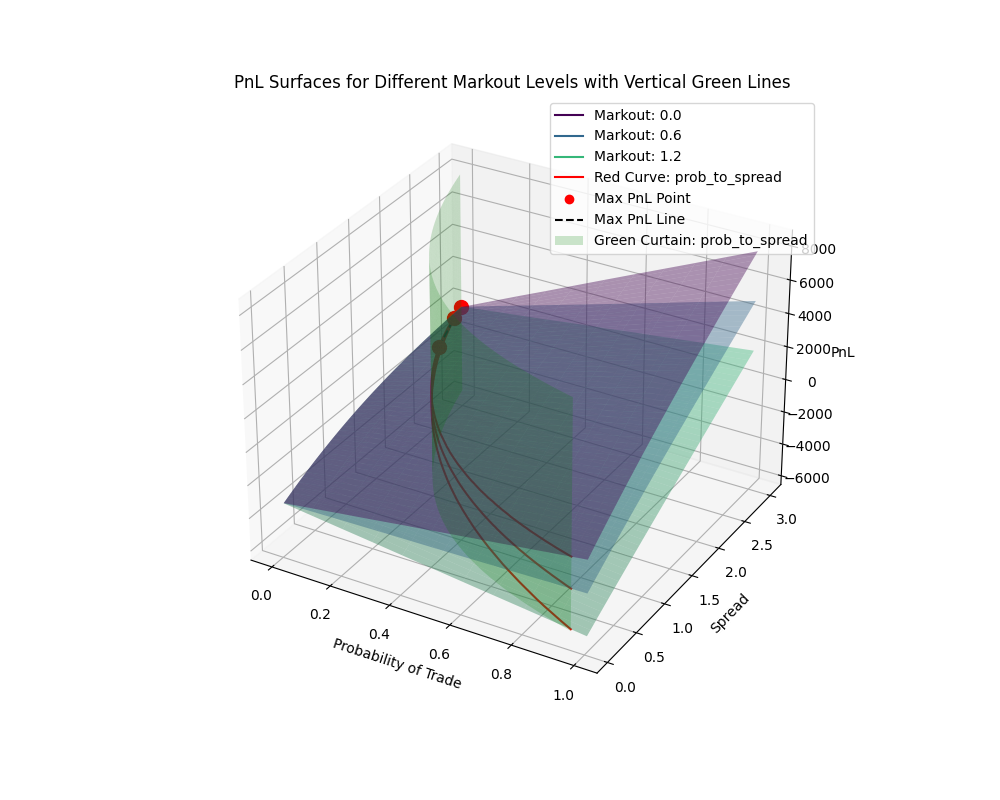

In [70]:
plt.close('all')
# Define min and max PnL values for the green "curtain"
min_pnl = np.min([np.min(surface) for surface in markout_surfaces.values()])
max_pnl = np.max([np.max(surface) for surface in markout_surfaces.values()])

# Create a meshgrid for the green "curtain"
Z_curtain, Y_curtain = np.meshgrid(np.linspace(min_pnl, max_pnl, 100), spreads)
X_curtain = np.tile(prob_from_spread, (100, 1)).T  # X is the same for every spread

# Initialize list to store maximum PnL points for each markout level
max_pnl_points_markout = []

# Plot surfaces for different markout levels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('PnL Surfaces for Different Markout Levels')
ax.set_xlabel('Probability of Trade')
ax.set_ylabel('Spread')
ax.set_zlabel('PnL')

for i, (markout, surface) in enumerate(markout_surfaces.items()):
    # Plot original PnL surface
    X, Y = np.meshgrid(probability_of_trades, spreads)
    ax.plot_surface(X, Y, surface, alpha=0.4, color=cmap(i / len(markout_surfaces)))

    # Create the continuous PnL surface
    pnls_interpolated = RectBivariateSpline(spreads, probability_of_trades, surface)

    # Calculate the PnLs for the red curve using the continuous PnL surface
    red_curve_pnls = pnls_interpolated(spreads, prob_from_spread, grid=False)

    # Draw the red curve
    ax.plot(prob_from_spread, spreads, red_curve_pnls, 'r')

    # Find the maximum PnL on the red curve
    max_spread, max_prob, max_pnl = find_max_pnl(spreads, prob_from_spread, red_curve_pnls)
    max_pnl_points_markout.append((max_prob, max_spread, max_pnl))

    # Draw the point of max PnL on the red line
    ax.scatter(max_prob, max_spread, max_pnl, color='r', s=100)

# Connect the max PnL points
max_pnl_points_markout = np.array(max_pnl_points_markout)
ax.plot(max_pnl_points_markout[:, 0], max_pnl_points_markout[:, 1], max_pnl_points_markout[:, 2], 'k--')

# Draw the green "curtain"
ax.plot_surface(X_curtain, Y_curtain, Z_curtain, alpha=0.2, color='g')

# Create legend
legend_elements = [mlines.Line2D([], [], color=cmap(i / len(markout_surfaces)), label=f'Markout: {markout}') for i, markout in enumerate(markout_surfaces)]
legend_elements.append(mlines.Line2D([], [], color='red', label='Max PnL Line from Markout changes'))
legend_elements.append(mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Max PnL Point from Markout changes'))
legend_elements.append(mlines.Line2D([], [], color='black', linestyle='dashed', label='Max PnL Line'))
legend_elements.append(Patch(facecolor='green', alpha=0.2, label='Client sensitivity to spread'))
ax.legend(handles=legend_elements, loc='best')

plt.show()


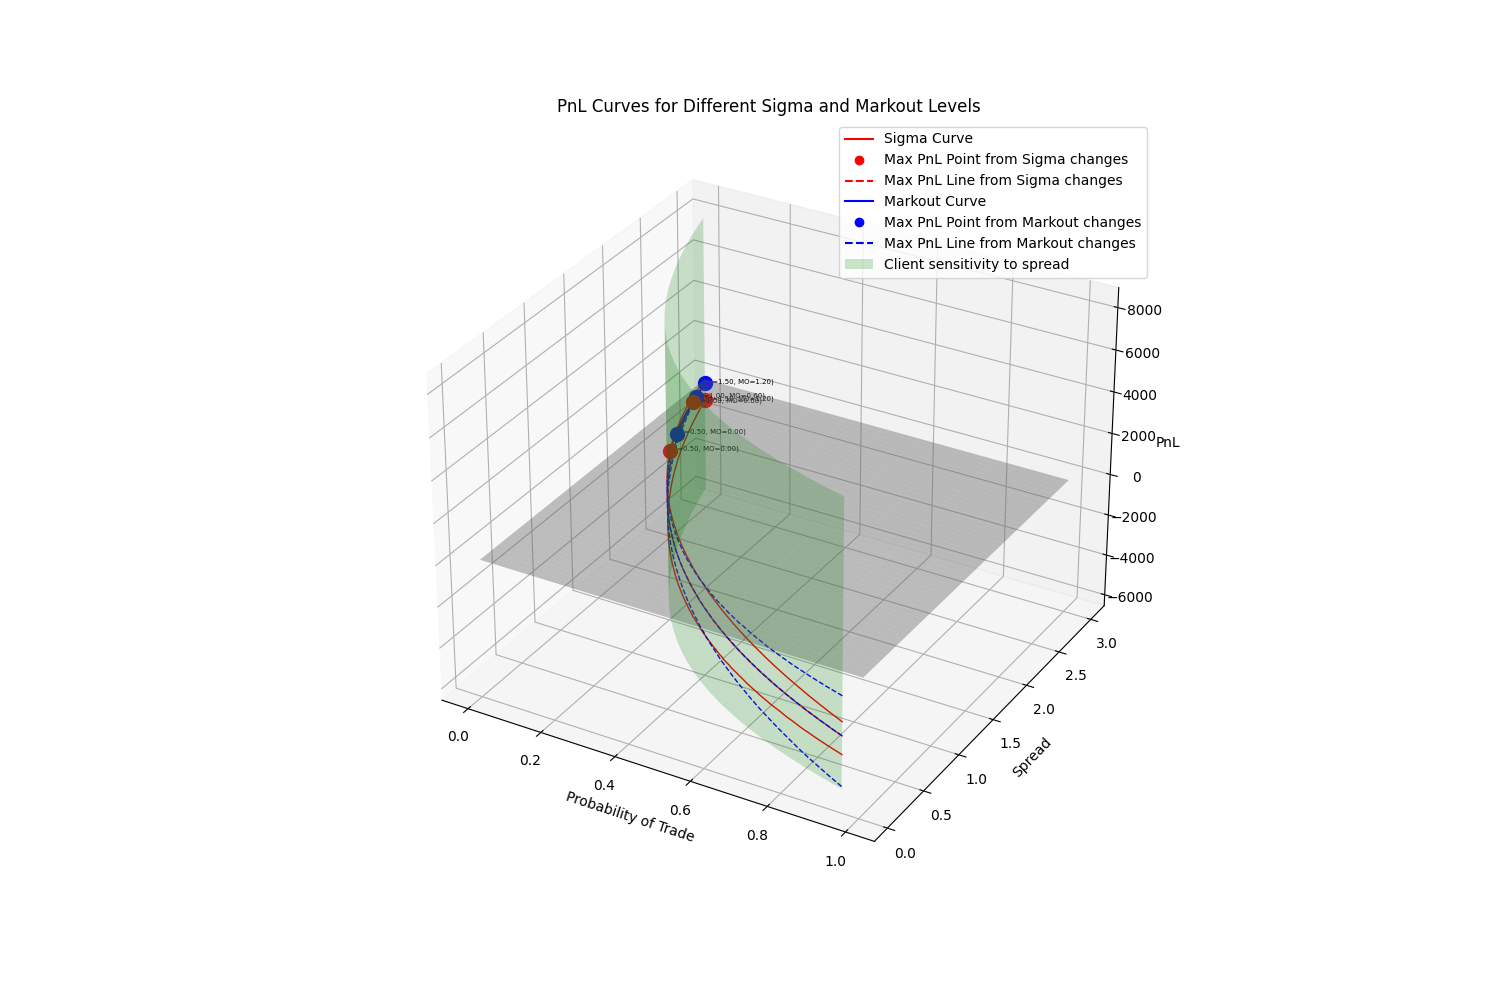


Maximum PnL Points for Different Sigma Levels:
Sigma: 0.50, Markout: 0.60, PnL: 275.04
Sigma: 1.00, Markout: 0.60, PnL: -182.06
Sigma: 1.50, Markout: 0.60, PnL: -1068.47

Maximum PnL Points for Different Markout Levels:
Sigma: 1.00, Markout: 0.00, PnL: 8.81
Sigma: 1.00, Markout: 0.60, PnL: -173.77
Sigma: 1.00, Markout: 1.20, PnL: -205.88


In [71]:
plt.close('all')

# Determine overall min and max PnL values for the green "curtain"
min_pnl = min(np.min([np.min(surface) for surface in sigma_surfaces.values()]),
              np.min([np.min(surface) for surface in markout_surfaces.values()]))
max_pnl = max(np.max([np.max(surface) for surface in sigma_surfaces.values()]),
              np.max([np.max(surface) for surface in markout_surfaces.values()]))

# Create a meshgrid for the green "curtain" and zero PnL plane
Z_curtain, Y_curtain = np.meshgrid(np.linspace(min_pnl, max_pnl, 100), spreads)
X_curtain = np.tile(prob_from_spread, (100, 1)).T  # X is the same for every spread



X_zero_pnl, Y_zero_pnl = np.meshgrid(probability_of_trades, spreads)
Z_zero_pnl = np.zeros_like(X_zero_pnl)

# Initialize lists to store maximum PnL points
max_pnl_points_sigma = []
max_pnl_points_markout = []

# Create 3D figure
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('PnL Curves for Different Sigma and Markout Levels')
ax.set_xlabel('Probability of Trade')
ax.set_ylabel('Spread')
ax.set_zlabel('PnL')

# Draw red curves and calculate maximum PnL points for different sigma levels
for i, (sigma, surface) in enumerate(sigma_surfaces.items()):
    # Create the continuous PnL surface
    pnls_interpolated = RectBivariateSpline(spreads, probability_of_trades, surface)
    # Calculate the PnLs for the red curve using the continuous PnL surface
    red_curve_pnls = pnls_interpolated(spreads, prob_from_spread, grid=False)
    # Draw the red curve
    ax.plot(prob_from_spread, spreads, red_curve_pnls, color='r', linewidth=1)
    # Find the maximum PnL on the red curve
    max_spread, max_prob, max_pnl = find_max_pnl(spreads, prob_from_spread, red_curve_pnls)
    max_pnl_points_sigma.append((max_prob, max_spread, max_pnl))
    # Draw the point of max PnL on the red line
    ax.scatter(max_prob, max_spread, max_pnl, color='r', s=100)
    # Annotate the point with sigma value
    ax.text(max_prob, max_spread, max_pnl, f'(σ={sigma:.2f}, MO={markout_levels[i]:.2f})', color='black', fontsize=5)

# Draw red curves and calculate maximum PnL points for different markout levels
for i, (markout, surface) in enumerate(markout_surfaces.items()):
    # Create the continuous PnL surface
    pnls_interpolated = RectBivariateSpline(spreads, probability_of_trades, surface)
    # Calculate the PnLs for the red curve using the continuous PnL surface
    red_curve_pnls = pnls_interpolated(spreads, prob_from_spread, grid=False)
    # Draw the red curve
    ax.plot(prob_from_spread, spreads, red_curve_pnls, color='b', linewidth=1, linestyle='--')
    # Find the maximum PnL on the red curve
    max_spread, max_prob, max_pnl = find_max_pnl(spreads, prob_from_spread, red_curve_pnls)
    max_pnl_points_markout.append((max_prob, max_spread, max_pnl))
    # Draw the point of max PnL on the red line
    ax.scatter(max_prob, max_spread, max_pnl, color='b', s=100)
    # Annotate the point with markout value
    ax.text(max_prob, max_spread, max_pnl, f'(σ={sigma_levels[i]:.2f}, MO={markout:.2f})', color='black', fontsize=5)

# Connect the max PnL points along the curtain surface
for i in range(1, len(max_pnl_points_sigma)):

    y_vals = np.linspace(max_pnl_points_sigma[i-1][1], max_pnl_points_sigma[i][1], 100)
    x_vals = prob_to_spread(y_vals)
    z_vals = np.linspace(max_pnl_points_sigma[i-1][2], max_pnl_points_sigma[i][2], 100)
    ax.plot(x_vals, y_vals, z_vals, 'r-')

for i in range(1, len(max_pnl_points_markout)):

    y_vals = np.linspace(max_pnl_points_markout[i-1][1], max_pnl_points_markout[i][1], 100)
    x_vals = prob_to_spread(y_vals)
    z_vals = np.linspace(max_pnl_points_markout[i-1][2], max_pnl_points_markout[i][2], 100)
    ax.plot(x_vals, y_vals, z_vals, 'b-')



# Draw the zero PnL plane
ax.plot_surface(X_zero_pnl, Y_zero_pnl, Z_zero_pnl, alpha=0.4, color='gray')
# Draw the green "curtain"
ax.plot_surface(X_curtain, Y_curtain, Z_curtain, alpha=0.2, color='g')



# Create legend
legend_elements = [mlines.Line2D([], [], color='red', label='Sigma Curve'),
                   mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Max PnL Point from Sigma changes'),
                   mlines.Line2D([], [], color='red', linestyle='dashed', label='Max PnL Line from Sigma changes'),
                   mlines.Line2D([], [], color='blue', label='Markout Curve'),
                   mlines.Line2D([], [], color='blue', marker='o', linestyle='None', label='Max PnL Point from Markout changes'),
                   mlines.Line2D([], [], color='blue', linestyle='dashed', label='Max PnL Line from Markout changes'),
                   Patch(facecolor='green', alpha=0.2, label='Client sensitivity to spread')]
ax.legend(handles=legend_elements, loc='best')



plt.show()

# Printing the maximum PnL points for different sigma levels
print("\nMaximum PnL Points for Different Sigma Levels:")
for i, point in enumerate(max_pnl_points_sigma):
    sigma = sigma_levels[i]
    print(f'Sigma: {sigma:.2f}, Markout: {markout_levels[1]:.2f}, PnL: {point[2]:.2f}')

# Printing the maximum PnL points for different markout levels
print("\nMaximum PnL Points for Different Markout Levels:")
for i, point in enumerate(max_pnl_points_markout):
    markout = markout_levels[i]
    print(f'Sigma: {sigma_levels[1]:.2f}, Markout: {markout:.2f}, PnL: {point[2]:.2f}')
